# Neural Network Performance on Manual CLustering

### Import Packages

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.callbacks import LearningRateScheduler
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout

### Data Preprocessing

In [17]:
data = pd.read_csv('dataset.csv')

# Drop unnecessary columns
data = data.drop(labels=['artists','track_id','album_name','track_name','Unnamed: 0'], axis=1)

# Change genre labels to narrow down the number of genres

data = data.replace(["salsa","latino","ska","samba","dancehall","reggaeton","reggae","brazil","tango"], "latin")

data = data.replace(["gospel","soul","blues","bluegrass","funk","jazz"],"r-n-b")

data = data.replace(["singer-songwriter","songwriter"],"folk")

data = data.replace(["honky-tonk","sertanejo","guitar","acoustic"], "country")

data = data.replace(["rockabilly","rock-n-roll","hard-rock","alt-rock","punk-rock","psych-rock","j-rock", "garage","grunge","emo"], "rock")

data = data.replace(["cantopop","j-pop","k-pop","power-pop","synth-pop","pop-film","indie-pop","mandopop"], "pop")

data = data.replace(["black-metal","heavy-metal","death-metal","metalcore"], "metal")

data = data.replace("grindcore", "punk")

data = data.replace(["disney","children"], "kids")

data = data.replace(["pagode","drum-and-bass","edm","electro","idm","ambient","breakbeat","new-age",
                     "chicago-house","progressive-house","house","trip-hop","dubstep","dub","trance",
                     "chill","deep-house","disco","afrobeat","hardcore","detroit-techno","minimal-techno","hardstyle","techno"], "electronic")

data = data.replace("folk","country")

data = data.replace("punk","rock")

data = data.replace("piano","classical")

# Drop ambiguous or too generlized genres
data = data.loc[-data["track_genre"].isin(["mpb", "forro", "indie", "opera", "party", "alternative", "happy", "industrial", "sad",
                                            "british", "french",  "anime", "club", "dance", "goth", "groove", "study", "show-tunes",
                                           "comedy", "german", "indian", "malay", "latino", "spanish", "swedish", "sleep",
                                           "turkish", "world-music", "iranian", 'j-dance','j-idol',"romance"])]

# Take the top five most frequent genres
data = data.loc[-data['track_genre'].isin(['hip-hop','classical','kids','metal','r-n-b'])]

In [18]:
data['track_genre'].value_counts()

track_genre
electronic    25000
rock          13000
latin         10000
pop            9000
country        8000
Name: count, dtype: int64

In [19]:
genres = ['electronic','rock','latin','pop','country']

# Take a sample of 8000 songs from each genre and create a new dataframe
sampled_df = pd.DataFrame()
for i,genre in enumerate(genres):
    cluster = data[data['track_genre'] == genre]
    samples = cluster.sample(8000)
    sampled_df = pd.concat([sampled_df, samples], axis=0)
data = sampled_df

In [20]:
# Split the data into the predictor matrix and target variable
X = data.drop(labels=['track_genre'], axis=1)
y = data['track_genre']

In [21]:
# Convert the categorical data (genres) to numerical data by assigning integers to each genre
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [22]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32000, 15), (8000, 15), (32000,), (8000,))

In [23]:
# Standardize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Model Construction

In [24]:
num_features = X_train.shape[1]
num_genres = np.unique(y_train).shape[0]

# Create the model
def create_model(optimizer='adam', activation='relu'):
    model = Sequential()
    model.add(Dense(512, activation=activation, input_shape=(num_features,)))
    model.add(Dense(256, activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = activation))
    model.add(Dense(num_genres, activation = 'softmax'))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [25]:
model = create_model()

In [26]:
# Create a learning rate scheduler to adapt the learning rate as the model trains
def scheduler(epoch, lr):
  return lr*0.9

callback = LearningRateScheduler(scheduler)

### Training

In [27]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks = [callback])

Epoch 1/20
900/900 [==============================] - 5s 4ms/step - loss: 1.2753 - accuracy: 0.4804 - val_loss: 1.2988 - val_accuracy: 0.4812 - lr: 9.0000e-04
Epoch 2/20
900/900 [==============================] - 4s 4ms/step - loss: 1.2056 - accuracy: 0.5153 - val_loss: 1.2090 - val_accuracy: 0.5175 - lr: 8.1000e-04
Epoch 3/20
900/900 [==============================] - 4s 4ms/step - loss: 1.1792 - accuracy: 0.5283 - val_loss: 1.1843 - val_accuracy: 0.5266 - lr: 7.2900e-04
Epoch 4/20
900/900 [==============================] - 4s 4ms/step - loss: 1.1500 - accuracy: 0.5421 - val_loss: 1.1765 - val_accuracy: 0.5328 - lr: 6.5610e-04
Epoch 5/20
900/900 [==============================] - 4s 4ms/step - loss: 1.1281 - accuracy: 0.5512 - val_loss: 1.1319 - val_accuracy: 0.5584 - lr: 5.9049e-04
Epoch 6/20
900/900 [==============================] - 4s 4ms/step - loss: 1.1054 - accuracy: 0.5642 - val_loss: 1.1158 - val_accuracy: 0.5612 - lr: 5.3144e-04
Epoch 7/20
900/900 [==========================

### Testing

In [28]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

250/250 [==============================] - 1s 2ms/step - loss: 1.0307 - accuracy: 0.5978
Test Loss: 1.0307190418243408
Test Accuracy: 0.5977500081062317


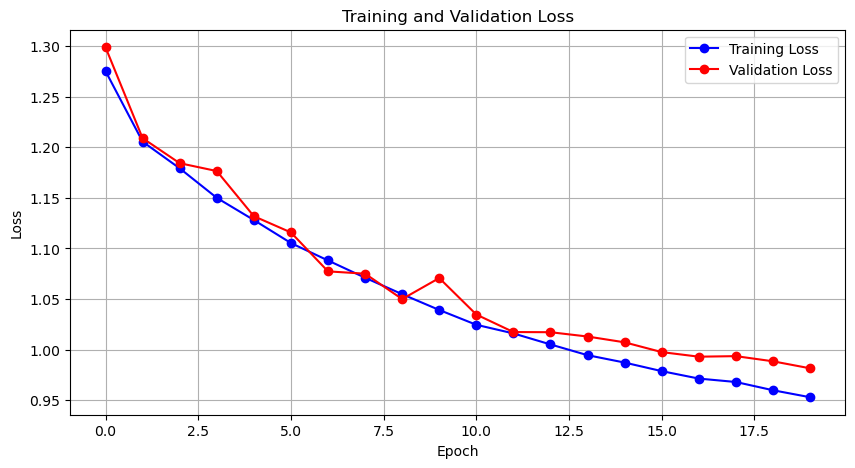

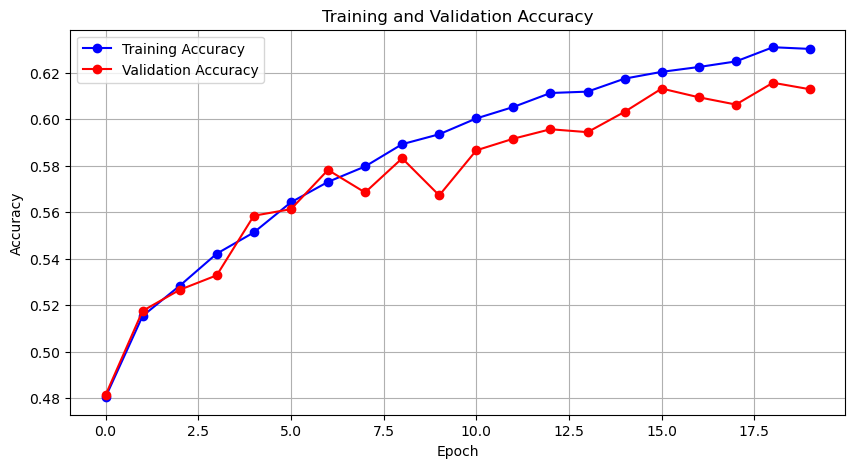

In [29]:
# Extract training and validation loss from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extract training and validation accuracy from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(val_loss, label='Validation Loss', color='red', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy', color='blue', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', color='red', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
